In [1]:
import os
import pandas as pd
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Set up logging
logging.basicConfig(level=logging.INFO)

In [2]:
def extract_date_from_filename(file_name):
    """
    Extracts a date from the file name using a predefined format.
    Args:
    file_name (str): The name of the file.
    Returns:
    datetime: The extracted date.
    """
    date_str = file_name.split('_')[-1].split('.')[0]
    return datetime.strptime(date_str, '%Y%m%d')

def load_file(full_file_path):
    """
    Loads a file into a DataFrame based on its extension.
    Args:
    full_file_path (str): Full path to the file.
    Returns:
    DataFrame: Loaded data or None if the file format is not supported.
    """
    file_extension = os.path.splitext(full_file_path)[1]
    if file_extension == '.parquet':
        return pd.read_parquet(full_file_path)
    return None

def load_and_process_files(folder_path):
    """
    Loads and processes files from a given folder.
    Args:
    folder_path (str): Path to the folder containing files.
    Returns:
    DataFrame: Concatenated DataFrame of all processed files.
    List[str]: List of files that failed to load.
    """
    file_list = os.listdir(folder_path)
    dataframes, failed_to_load = [], []

    for file in file_list:
        full_file_path = os.path.join(folder_path, file)
        try:
            df = load_file(full_file_path)
            if df is not None:
                df['date'] = extract_date_from_filename(file)
                dataframes.append(df)
        except Exception as e:
            logging.error(f"Failed to load file {file}. Error: {e}")
            failed_to_load.append(file)

    if failed_to_load:
        logging.info("The following files failed to load: %s", failed_to_load)
    else:
        logging.info("All files loaded successfully.")

    return pd.concat(dataframes, ignore_index=True), failed_to_load

# Define folder path
folder_path = r"Volumes/qr_takehome"

# Load and process files
full_data, failed_to_load = load_and_process_files(folder_path)
print("Data size before cleaning:", full_data.shape)


INFO:root:All files loaded successfully.


Data size before cleaning: (6705000, 383)


In [3]:
# Function to remove outliers
def replace_outliers_with_na(data, columns):
    """
    Replaces outliers in the specified columns of the DataFrame with NA based on the IQR method.
    Args:
    data (DataFrame): The DataFrame to process.
    columns (list): List of column names to check for outliers.
    Returns:
    DataFrame: Data with outliers replaced by NA.
    """
    for column in columns:
        if data[column].dtype in ['float64', 'float32', 'int64', 'int32']:
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            outlier_filter = ~((data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR))
            data.loc[outlier_filter, column] = pd.NA
    return data

# Replace specific value with NA
full_data.replace(999999, pd.NA, inplace=True)
# Split data into in-sample and out-of-sample
in_sample_end_date = datetime(2023, 2, 28)
in_sample_data = full_data[full_data['date'] <= in_sample_end_date]
out_of_sample_data = full_data[full_data['date'] > in_sample_end_date]

# Identifying columns starting with 'X' and removing outliers
x_columns = [col for col in in_sample_data.columns if col.startswith('X')]
# in_sample_data = replace_outliers_with_na(in_sample_data, x_columns)

In [4]:
# Data save
in_sample_data.to_parquet('Datasave/in_sample_data.parquet', compression='gzip')
out_of_sample_data.to_parquet('Datasave/out_of_sample_data.parquet', compression='gzip')


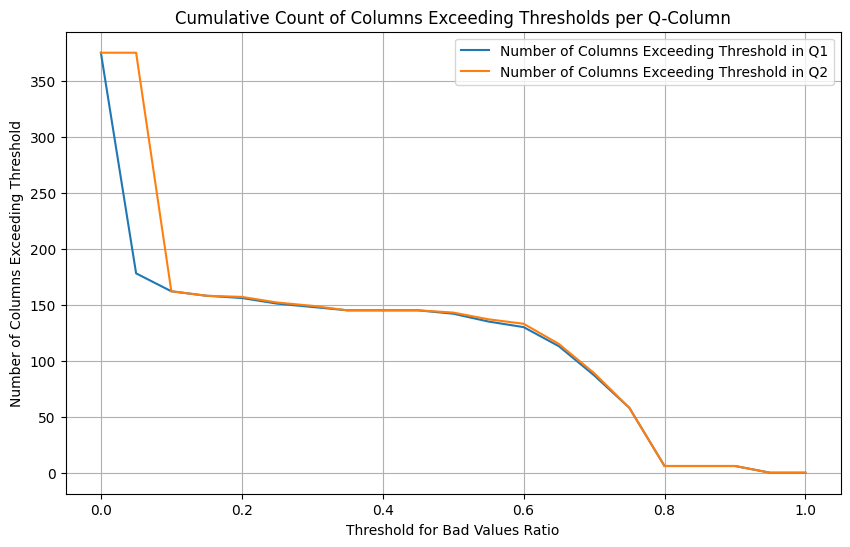

In [5]:
# Function to calculate the ratio of bad values in a column
def calculate_bad_value_ratio(data, column, q_column):
    """
    Calculates the ratio of bad values in a specific column based on a quality metric column.
    Args:
    data (DataFrame): The DataFrame containing the data.
    column (str): The name of the column to calculate the ratio for.
    q_column (str): The name of the quality metric column.
    Returns:
    float: The ratio of bad values in the column.
    """
    # Mark values as NA in the column if the corresponding value in the quality column is below a threshold
    data.loc[data[q_column] < 0.9999, column] = pd.NA

    # Count the number of NA, null, or zero values
    bad_values_count = data[column].isna().sum() + (data[column] == 0).sum()

    # Calculate and return the ratio of bad values in the column
    return bad_values_count / len(data[column])

# Function to get cumulative counts of bad values
def get_cumulative_counts(data, x_columns, q_columns, thresholds):
    """
    Calculates cumulative counts of columns exceeding various thresholds for bad values.
    Args:
    data (DataFrame): The DataFrame containing the data.
    x_columns (list): List of columns to check.
    q_columns (list): List of quality columns.
    thresholds (list): List of thresholds to check against.
    Returns:
    dict: A dictionary with cumulative counts.
    """
    cumulative_counts = {}
    for q_col in q_columns:
        # Calculate bad value ratio for each column
        ratios = [calculate_bad_value_ratio(data, x, q_col) for x in x_columns]
        # Count the number of columns exceeding each threshold
        cumulative_counts[q_col] = {threshold: np.sum(np.array(ratios) >= threshold) for threshold in thresholds}
    return cumulative_counts

# Function to plot cumulative counts
def plot_cumulative_counts(cumulative_counts, q_columns, thresholds, save_path):
    """
    Plots the cumulative counts of columns exceeding various thresholds for bad values.
    Args:
    cumulative_counts (dict): Dictionary with cumulative counts.
    q_columns (list): List of quality columns.
    thresholds (list): List of thresholds used.
    save_path (str): Path to save the plot.
    """
    plt.figure(figsize=(10, 6))
    # Plot counts for each quality column
    for q_col in q_columns:
        counts = [cumulative_counts[q_col][th] for th in thresholds]
        plt.plot(thresholds, counts, label=f'Number of Columns Exceeding Threshold in {q_col}')
    
    # Set plot labels and title
    plt.xlabel('Threshold for Bad Values Ratio')
    plt.ylabel('Number of Columns Exceeding Threshold')
    plt.title('Cumulative Count of Columns Exceeding Thresholds per Q-Column')
    plt.legend()
    plt.grid(True)
    
    # Save the plot to the specified path
    plt.savefig(save_path)
    plt.show()

# Load in-sample data
in_sample_data = pd.read_parquet('Datasave/in_sample_data.parquet')
# Identify columns starting with 'X'
x_columns = [col for col in in_sample_data.columns if col.startswith('X')]
# Define quality columns and thresholds
q_columns = ['Q1', 'Q2']
thresholds = np.arange(0, 1.05, 0.05)  # Thresholds from 0 to 1 with a step of 0.05

# Calculate cumulative counts for bad values
cumulative_counts = get_cumulative_counts(in_sample_data, x_columns, q_columns, thresholds)

# Plot and save the cumulative counts
plot_save_path = 'Plot n result save/missing_value_cumulative_counts_plot.png'
plot_cumulative_counts(cumulative_counts, q_columns, thresholds, plot_save_path)


In [6]:
display(cumulative_counts)

{'Q1': {0.0: 375,
  0.05: 178,
  0.1: 162,
  0.15000000000000002: 158,
  0.2: 156,
  0.25: 151,
  0.30000000000000004: 148,
  0.35000000000000003: 145,
  0.4: 145,
  0.45: 145,
  0.5: 142,
  0.55: 135,
  0.6000000000000001: 130,
  0.65: 113,
  0.7000000000000001: 87,
  0.75: 58,
  0.8: 6,
  0.8500000000000001: 6,
  0.9: 6,
  0.9500000000000001: 0,
  1.0: 0},
 'Q2': {0.0: 375,
  0.05: 375,
  0.1: 162,
  0.15000000000000002: 158,
  0.2: 157,
  0.25: 152,
  0.30000000000000004: 149,
  0.35000000000000003: 145,
  0.4: 145,
  0.45: 145,
  0.5: 143,
  0.55: 137,
  0.6000000000000001: 133,
  0.65: 115,
  0.7000000000000001: 89,
  0.75: 58,
  0.8: 6,
  0.8500000000000001: 6,
  0.9: 6,
  0.9500000000000001: 0,
  1.0: 0}}

In [1]:
import pandas as pd
# Load in-sample data
in_sample_data = pd.read_parquet('Datasave/in_sample_data.parquet')
# Identify columns starting with 'X'
x_columns = [col for col in in_sample_data.columns if col.startswith('X')]

# Function to calculate the ratio of bad values in a column
def calculate_bad_value_ratio(data, column, q_column):
    """
    Calculates the ratio of bad values in a specific column based on a quality metric column.
    Args:
    data (DataFrame): The DataFrame containing the data.
    column (str): The name of the column to calculate the ratio for.
    q_column (str): The name of the quality metric column.
    Returns:
    float: The ratio of bad values in the column.
    """
    # Mark values as NA in the column if the corresponding value in the quality column is below a threshold
    data.loc[data[q_column] < 0.9999, column] = pd.NA

    # Count the number of NA, null, or zero values
    bad_values_count = data[column].isna().sum() + (data[column] == 0).sum()

    # Calculate and return the ratio of bad values in the column
    return bad_values_count / len(data[column])

In [2]:
def filter_bad_values_and_save(data, q_column, threshold, x_columns, temp_file_path):
    """
    Filters bad values from the data based on a threshold and saves the filtered data.
    Args:
    data (DataFrame): The DataFrame to process.
    q_column (str): The quality column to base the filtering on.
    threshold (float): The threshold for bad value ratio.
    x_columns (list): List of columns to filter.
    temp_file_path (str): Path to save the filtered data.
    Returns:
    DataFrame: The filtered DataFrame.
    """    
    additional_columns = []
    filtered_data = data.iloc[:,0:3].copy()
    filtered_data['date'] = data['date']
    if q_column == "Q1":
        filtered_data[["Y1", "Q1"]] = data[["Y1", "Q1"]]
    else:
        filtered_data[["Y2", "Q2"]] = data[["Y2", "Q2"]]

    additional_columns = []

    for column in x_columns:
        bad_values_ratio = calculate_bad_value_ratio(data, column, q_column)
        if bad_values_ratio < threshold:
            additional_columns.append(data[column])
    # Concatenate additional columns all at once
    filtered_data = pd.concat(  [filtered_data] + additional_columns, axis=1)

    # Sorting by 'date' and 'time'
    filtered_data.sort_values(by=['date', 'time'], inplace=True)
    filtered_data.to_parquet(temp_file_path)
    display(filtered_data)
    
    return filtered_data

# Filtering bad values and saving
for q_col in ['Q1', 'Q2']:
    print(f"Number's of parameter for {q_col} before cleaning: {len(x_columns)}")
    for i in [0.35]:
        in_sample_filtered = filter_bad_values_and_save(in_sample_data, q_col, i, x_columns, f'Datasave/{q_col}_filtered_{i}.parquet')
        x_columns_after = [col for col in in_sample_filtered.columns if col.startswith('X')]
        print(f"Number's of parameter for {q_col} after cleaning (threshold = {i}): {len(x_columns_after)}")
    print("")

Number's of parameter for Q1 before cleaning: 375


,time,sym,exch,date,Y1,Q1,X1,X10,X100,X101,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
0,35101000,SPX,cme,2022-01-03,-4.967191e+01,1.00,-1.985130,-0.440099,0.044736,-0.010772,...,0.036888,0.020226,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752
1,35102000,SPX,cme,2022-01-03,-4.889528e+01,1.00,-0.933646,-0.380986,-0.854499,-0.951011,...,-0.852265,-0.910145,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521
2,35103000,SPX,cme,2022-01-03,-4.706744e+01,1.00,-0.579249,-0.180915,-0.854372,-0.969687,...,-0.842401,-0.919075,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525
3,35104000,SPX,cme,2022-01-03,-4.759041e+01,1.00,-0.658292,-0.028344,-0.044026,-0.496256,...,-0.031957,-0.441668,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654
4,35105000,SPX,cme,2022-01-03,-4.811086e+01,1.00,-1.331419,-0.100419,0.273158,0.218558,...,0.281678,0.268776,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254995,57596000,SPX,cme,2023-02-28,-8.803647e+00,0.21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254996,57597000,SPX,cme,2023-02-28,-8.175329e+00,0.21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254997,57598000,SPX,cme,2023-02-28,-5.661267e+00,1.00,-1.213168,-1.136721,NaN,-0.878878,...,NaN,-0.866625,-1.709110,-1.746943,-1.751714,NaN,-0.377860,-1.943471,-1.894090,-1.764978
6254998,57599000,SPX,cme,2023-02-28,-3.774891e+00,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number's of parameter for Q1 after cleaning (threshold = 0.35): 230

Number's of parameter for Q2 before cleaning: 375


,time,sym,exch,date,Y2,Q2,X1,X10,X100,X101,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
0,35101000,SPX,cme,2022-01-03,-61.707756,1.00,-1.985130,-0.440099,0.044736,-0.010772,...,0.036888,0.020226,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752
1,35102000,SPX,cme,2022-01-03,-62.025402,1.00,-0.933646,-0.380986,-0.854499,-0.951011,...,-0.852265,-0.910145,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521
2,35103000,SPX,cme,2022-01-03,-57.324017,1.00,-0.579249,-0.180915,-0.854372,-0.969687,...,-0.842401,-0.919075,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525
3,35104000,SPX,cme,2022-01-03,-58.769417,1.00,-0.658292,-0.028344,-0.044026,-0.496256,...,-0.031957,-0.441668,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654
4,35105000,SPX,cme,2022-01-03,-59.984489,1.00,-1.331419,-0.100419,0.273158,0.218558,...,0.281678,0.268776,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254995,57596000,SPX,cme,2023-02-28,-5.074302,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254996,57597000,SPX,cme,2023-02-28,-4.039149,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254997,57598000,SPX,cme,2023-02-28,-1.761056,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6254998,57599000,SPX,cme,2023-02-28,-1.346745,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number's of parameter for Q2 after cleaning (threshold = 0.35): 230



In [3]:
from datetime import datetime
import pandas as pd
import numpy as np

def convert_to_timeseries_and_save(file_path, output_file_path):
    # Load the data
    df = pd.read_parquet(file_path)

    # Convert 'time' from milliseconds to a standard time format
    df['time'] = pd.to_datetime(df['time'], unit='ms', origin='unix').dt.time

    # Combine 'date' and 'time' columns to create a 'datetime' column
    datetime_col = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    # Concatenate the new 'datetime' column to the DataFrame
    df = pd.concat([df, datetime_col.rename('datetime')], axis=1)

    # Set the new 'datetime' column as the index
    df.set_index('datetime', inplace=True)

    # Save the transformed DataFrame
    df.to_parquet(output_file_path)


# Apply the function to your files and save the transformed DataFrames
convert_to_timeseries_and_save('Datasave/Q1_filtered_0.35.parquet', 'Datasave/Q1_filtered2_0.35.parquet')
convert_to_timeseries_and_save('Datasave/Q2_filtered_0.35.parquet', 'Datasave/Q2_filtered2_0.35.parquet')


In [4]:
import pandas as pd

def resample_and_save(file_path, save_path, frequency):
    # Read the data from the parquet file
    df = pd.read_parquet(file_path)

    # Check if 'time' is the index and in datetime format; if not, set it accordingly
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index of DataFrame is not in datetime format. Please set the 'time' column as a datetime index.")

    # Drop rows where Q1 or Q2 is not equal to 1, depending on the dataset
    if 'Q1' in df.columns:
        df = df[df['Q1'] == 1]
    elif 'Q2' in df.columns:
        df = df[df['Q2'] == 1]

    # Resample the data into specified intervals
    resampled_df = df.resample(frequency).mean()

    # Save the resampled data into a new parquet file
    resampled_df.to_parquet(save_path)

    display(resampled_df)

# Call the function for each dataset with specific file paths
resample_and_save('Datasave/Q1_filtered2_0.35.parquet', 'Datasave/Q1_resample_20min_0.35.parquet', '20T')
resample_and_save('Datasave/Q2_filtered2_0.35.parquet', 'Datasave/Q2_resample_20min_0.35.parquet', '20T')
resample_and_save('Datasave/Q1_filtered2_0.35.parquet', 'Datasave/Q1_resample_1H_0.35.parquet', '1H')
resample_and_save('Datasave/Q2_filtered2_0.35.parquet', 'Datasave/Q2_resample_1H_0.35.parquet', '1H')


TypeError: agg function failed [how->mean,dtype->object]